# KV Cache

Key-Value Cache是在Transformer自回归模型推理阶段中，为了加速推理、减少重复计算而引入的缓存机制 \
具体来说，就是在推理时，给每个生成的token计算K和V矩阵，KV Cache将这些矩阵存储在内存中，以便后续生成token的时候，只需要为新的token计算K和V，而不是重新计算所有当前已生成token的K和V

# MHA，MQA和GQA

Transofmrer里每一层的注意力通常是基于Multi-Head Attention, MHA称为多头注意力。这个模块的核心是把模型的总隐藏维度$d_{model}$拆分为多个头，每个头独立地进行注意力计算，再将结果拼接起来，投影回原始空间 \
每个头head可以专注不同的子空间，捕捉不同的语义、结构关系。多头并行，就相当于多个子空间并行抽取特征，最后拼接后再映射 \

> MQA：每个注意力头保留独立地Query（Q）向量，但所有注意力头共享一组Key(K)和Value(V)向量，减少计算和缓存中K/V的显存冗余压力 \
> 但是K和V只有一个头，所有头的Q都共享这一对K和V，导致Query无法获取独立地上下文信息，限制了模型捕捉多样化注意力模式的能力 \

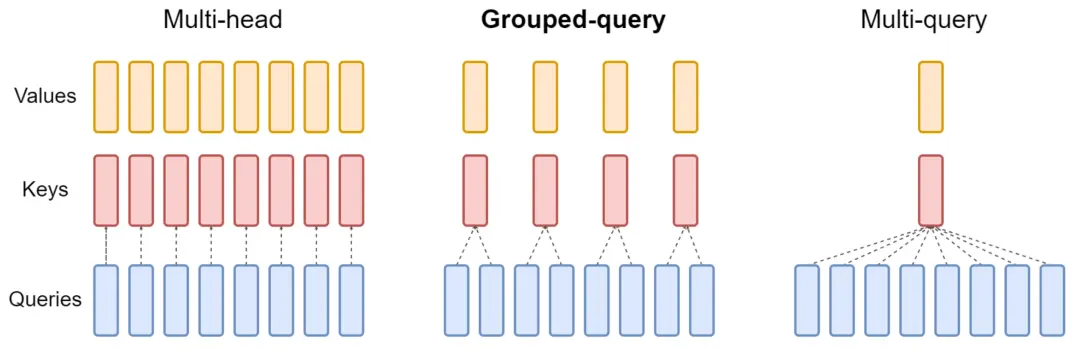

Group Query Attention里面的`num_kv_heads`这个参数不是算出来，是人为设定的

KV Cache的大小是【Byte】= `batch_size * num_kv_heads * seq_len * head_dim * float_size`

# Flash Attention

Flash Attention是一种显存优化 + 更快计算的注意力实现，数学本质不变，只是在实现细节上做了大量工程优化，尤其适用于长序列Transformer模型（如LLM）。

In [ ]:
# Optional就是None或者X类型
# Tuple固定长度的元组类型
# List[X]列表里面都是X类型
# Union变量可以是A或者B类型
from typing import Optional, Tuple, List, Union
import torch.nn.functional as F
import torch.nn as nn
import torch
import math

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    # 重复KV Head
    bs, slen, num_key_value_heads, head_dim = x.shape
    if n_rep == 1:
        # 不需要重复
        return x
    # 需要重复的话，None等价于np.newaxis，插入一个新维度
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, num_key_value_heads, n_rep, head_dim) # 扩展维度
        .reshape(bs, slen, num_key_value_heads * n_rep, head_dim)
    )

class Attention(nn.Module):
    def __init__(self, args):
        super().__init__()
        # 支持多query-head共享同一个key-value-head
        self.num_key_value_heads = args.num_attention_heads if args.num_key_value_heads is None else args.num_key_value_heads
        assert args.num_attention_heads % self.num_key_value_heads == 0 # 保证Q Head数量是KV Head数量的整数倍

        self.n_local_heads = args.num_attention_heads # 总Q Head数量
        self.n_local_kv_heads = self.num_key_value_heads # k/v head数
        self.n_rep = self.n_local_heads // self.n_local_kv_heads # 每个k/v head被多少个query head共享

        self.head_dim = args.hidden_size // args.num_attention_heads # 每个head的维度

        # QKV线性映射层，没有偏置
        self.q_proj =  nn.Linear(args.hidden_size, args.num_attention_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(args.hidden_size, self.num_key_value_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(args.hidden_size, self.num_key_value_heads * self.head_dim, bias=False)
        # 输出线性映射层
        self.o_proj = nn.Linear(args.num_attention_heads * self.head_dim, args.hidden_size, bias=False)

        # Dropout
        self.attn_dropout = nn.Dropout(args.dropout)
        self.resid_dropout = nn.Dropout(args.dropout)
        self.dropout = args.dropout

        # 是否启用Flash Attention
        self.flash = hasattr(torch.nn.functional, "scaled_dot_product_attention") and args.use_flash_attn
    
    def forward(
            self,
            x: torch.Tensor, # 输入特征 (batch_size, seq_len, hidden_size
            position_embeddings: Tuple[torch.Tensor, torch.Tensor], # 旋转位置编码的cos/sin
            past_key_value: Optional[Tuple[torch.Tensor, torch.Tensor]] = None, # kv缓存
            use_cache = False, # 是否返回kv_cache
            attention_mask: Optional[torch.Tensor] = None, # 注意力掩码
    ):
        bsz, seq_len = x.shape

        # 线性变换
        xq = self.q_proj(x) # [batch_size, seq_len, n_heads * head_dim]
        xk = self.k_proj(x) # [batch_size, seq_len, n_kv_heads * head_dim]
        xv = self.v_proj(x) # [batch_size, seq_len, n_kv_heads * head_dim]

        # reshape为多头
        xq = xq.view(bsz, seq_len, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seq_len, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seq_len, self.n_local_kv_heads, self.head_dim)

        # 应用 rotary position embedding
        cos, sin = position_embeddings
        # 只截取seq_len
        xq, xk = apply_rotary_pos_emb(xq, xk, cos[:seq_len], sin[:seq_len])

        # 处理KV缓存：把历史的 key/value 与当前拼接
        if past_key_value is not None:
            xk = torch.cat([past_key_value[0], xk], dim=1)
            xv = torch.cat([past_key_value[1], xv], dim=1)
        
        past_kv = (xk, xv) if use_cache else None 

        # KV head重复拓展 -> 让所有Q head对应到正确的KV head
        xq = xq.transpose(1,2) # [bsz, n_heads, seq_len, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2)
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2)

        # Flash Attention 方法
        if self.flash and seq_len != 1:
            dropout_p = self.dropoutout if self.training else 0.0
            attn_mask = None
            if attention_mask is not None:
                attn_mask = attention_mask.view(bsz, 1, 1, -1).expand(bsz, self.n_local_heads, seq_len, -1)
                attn_mask = attn_mask.bool()
            
            # 使用Pytorch原生flash attention
            output = F.scsaled_dot_product_attention(
                xq, xk, xv,
                attn_mask = attn_mask,
                dropout_p = dropout_p,
                is_causal = True
            )
        # 普通 attention
        else:
            # 注意力分数计算
            scores = (xq @ xk.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [bsz, n_heads, q_len, k_len]

            # 上三角矩阵，对角线以下都是0
            scores = scores + torch.triu(
                torch.full((seq_len, seq_len), float("-inf"), device=scores.device),
                diagonal=1
            ).unsqueeze(0).unsqueeze(0) # 上三角变成-inf经过softmax趋于0, 掩盖未来的信息

            # attention掩码, 保证padding token这些不影响模型
            if attention_mask is not None:
                extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2) # [bsz, seq_len] -> [bsz, 1, 1, seq_len]
                extended_attention_mask = (1.0 - extended_attention_mask) * -1e9
                scores = scores + extended_attention_mask # 这个地方经过softmax就会近似为0
            # softmax + dropout
            scores = F.softmax(scores.float(), dim=-1).type_as(xq)
            scores = self.attn_dropout(scores)

            # 注意力加权求和
            output = scores @ xv # [bsz, n_heads, q_len, head_dim]

        # 还原输出形状，并通过输出线性层
        output = output.transpose(1, 2).reshape(bsz, seq_len, -1)
        output = self.resid_dropout(self.o_proj(output))

        return output, past_kv

d:\miniconda3\envs\minimind\lib\site-packages\torch\cuda\__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
